In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, ShuffleSplit, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, plot_confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
import category_encoders as ce

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

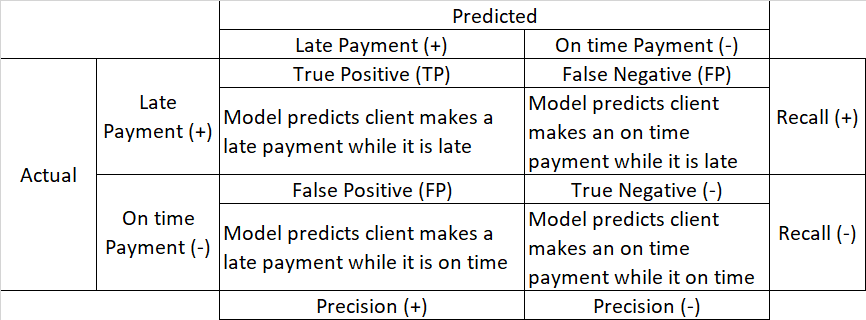

**Analytic Approach**

This project will aims at creating a model that is predicting (Predictive) client late payment probability using the data.The data will be analyze to obtain pattern that differentiate between client who will make a late payment and customer who is not make a late payment. With the classification model obatained prescribtion will be formulated to prevent company to approved client who is going to make a late payment.

**Metric Evaluation**

Type 1 error : False Positive (Model predicts client makes a late payment while it is on time)/REJECTED

Consequence: losing potention revenue (admin commission fee 1% and 3% flat each month).
            
Type 2 error : False Negative (Model predicts client makes an on time payment while it is late)/APPROVED

Consequence: late revenue and additional cost for catching up the late revenue.

RECALL(+) CHURN

Based on the consequences, what we will is to create a model that can prevent company to lose potention revenue, but without adding more cost for catching up the late revenue by the client. So we have to balance later between precision and recall from the positive class (potential candidate). So later the main metric that we will use is roc_auc.

In [2]:
pd.set_option('display.max_colwidth', 3000)
col_desc = pd.read_csv('ind_columns_description.csv')
col_desc

,Table,Columns,Description
0,loanapptrain.csv / loanapptest.csv,LN_ID,Loan ID
1,loanapptrain.csv / loanapptest.csv,TARGET,"Target variable (1 - client with late payment more than X days, 0 - all other cases)"
2,loanapptrain.csv / loanapptest.csv,CONTRACT_TYPE,Identification if loan is cash or revolving
3,loanapptrain.csv / loanapptest.csv,GENDER,Gender of the client
4,loanapptrain.csv / loanapptest.csv,NUM_CHILDREN,Number of children the client has
5,loanapptrain.csv / loanapptest.csv,INCOME,Monthly income of the client
6,loanapptrain.csv / loanapptest.csv,APPROVED_CREDIT,Approved credit amount of the loan
7,loanapptrain.csv / loanapptest.csv,ANNUITY,Loan annuity (amount that must be paid monthly)
8,loanapptrain.csv / loanapptest.csv,PRICE,For consumer loans it is the price of the goods for which the loan is given
9,loanapptrain.csv / loanapptest.csv,INCOME_TYPE,"Clients income type (businessman, working, maternity leave,…)"


In [2]:
df=pd.read_csv('ind_app_train.csv')
df.head()

,Unnamed: 0,LN_ID,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,...,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3
0,201468,333538,0,Revolving loans,F,1,67500.0,202500.0,10125.0,202500.0,...,-11539,-921,-119.0,-2757,TUESDAY,18,Business Entity Type 3,0.572805,0.608276,NaN
1,264803,406644,0,Cash loans,F,1,202500.0,976711.5,49869.0,873000.0,...,-15743,-4482,-1797.0,-2455,TUESDAY,14,Other,0.655600,0.684298,NaN
2,137208,259130,0,Cash loans,F,0,180000.0,407520.0,25060.5,360000.0,...,-20775,365243,-8737.0,-4312,THURSDAY,14,NA1,NaN,0.580687,0.749022
3,269220,411997,0,Cash loans,M,0,225000.0,808650.0,26086.5,675000.0,...,-20659,-10455,-4998.0,-4010,WEDNESDAY,10,Culture,NaN,0.623740,0.710674
4,122096,241559,0,Revolving loans,M,0,135000.0,180000.0,9000.0,180000.0,...,-9013,-1190,-3524.0,-1644,SUNDAY,11,Construction,0.175511,0.492994,0.085595


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61503 entries, 0 to 61502
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         61503 non-null  int64  
 1   LN_ID              61503 non-null  int64  
 2   TARGET             61503 non-null  int64  
 3   CONTRACT_TYPE      61503 non-null  object 
 4   GENDER             61503 non-null  object 
 5   NUM_CHILDREN       61503 non-null  int64  
 6   INCOME             61503 non-null  float64
 7   APPROVED_CREDIT    61503 non-null  float64
 8   ANNUITY            61502 non-null  float64
 9   PRICE              61441 non-null  float64
 10  INCOME_TYPE        61503 non-null  object 
 11  EDUCATION          61503 non-null  object 
 12  FAMILY_STATUS      61503 non-null  object 
 13  HOUSING_TYPE       61503 non-null  object 
 14  DAYS_AGE           61503 non-null  int64  
 15  DAYS_WORK          61503 non-null  int64  
 16  DAYS_REGISTRATION  615

In [5]:
desc = []
for i in df.columns:
    desc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round(((df[i].isna().sum() / len(df)) * 100), 2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values
    ])

pd.DataFrame(desc, columns=[
    "Data Features",
    "Data Types",
    "Null",
    "Null Percentage",
    "Unique",
    "Unique Sample"
])

,Data Features,Data Types,Null,Null Percentage,Unique,Unique Sample
0,Unnamed: 0,int64,0,0.00,61503,"[90752, 57439]"
1,LN_ID,int64,0,0.00,61503,"[450490, 257424]"
2,TARGET,int64,0,0.00,2,"[1, 0]"
3,CONTRACT_TYPE,object,0,0.00,2,"[Cash loans, Revolving loans]"
4,GENDER,object,0,0.00,2,"[F, M]"
5,NUM_CHILDREN,int64,0,0.00,10,"[6, 8]"
6,INCOME,float64,0,0.00,861,"[86310.0, 346500.0]"
7,APPROVED_CREDIT,float64,0,0.00,3562,"[743463.0, 1267735.5]"
8,ANNUITY,float64,1,0.00,9374,"[25825.5, 46557.0]"
9,PRICE,float64,62,0.10,541,"[351000.0, 1273500.0]"


### Data Preprocessing

In [3]:
df.drop(['Unnamed: 0','LN_ID','EXT_SCORE_1','EXT_SCORE_2','EXT_SCORE_3'], axis=1, inplace=True)

ID is being dropped because it has unique value for every row or data and also it doesn't have no effect on the target, external score also being dropped because it is a score from external data that we know nothing about.

In [27]:
desc = []
for i in df.columns:
    desc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round(((df[i].isna().sum() / len(df)) * 100), 2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values
    ])

pd.DataFrame(desc, columns=[
    "Data Features",
    "Data Types",
    "Null",
    "Null Percentage",
    "Unique",
    "Unique Sample"
])

,Data Features,Data Types,Null,Null Percentage,Unique,Unique Sample
0,TARGET,int64,0,0.0,2,"[0, 1]"
1,CONTRACT_TYPE,object,0,0.0,2,"[Revolving loans, Cash loans]"
2,GENDER,object,0,0.0,2,"[F, M]"
3,NUM_CHILDREN,int64,0,0.0,10,"[8, 9]"
4,INCOME,float64,0,0.0,861,"[80550.0, 179100.0]"
5,APPROVED_CREDIT,float64,0,0.0,3562,"[745119.0, 1840117.5]"
6,ANNUITY,float64,1,0.0,9374,"[12370.5, 11601.0]"
7,PRICE,float64,62,0.1,541,"[468000.0, 702000.0]"
8,INCOME_TYPE,object,0,0.0,7,"[Student, State servant]"
9,EDUCATION,object,0,0.0,5,"[Academic degree, Secondary / secondary special]"


In [46]:
df[df['ANNUITY'].isna()]

,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE
43406,0,Cash loans,M,0,202500.0,360000.0,NaN,360000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-19762,-2498,-11285.0,-3305,FRIDAY,15,Other


In [47]:
df[df['PRICE'].isna()]

,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE
722,0,Revolving loans,F,0,125550.0,225000.0,11250.0,NaN,Working,Secondary / secondary special,Married,House / apartment,-18481,-3008,-5450.0,-2026,SATURDAY,13,Electricity
1448,0,Revolving loans,M,0,180000.0,270000.0,13500.0,NaN,Working,Secondary / secondary special,Single / not married,With parents,-10275,-1937,-4103.0,-2946,THURSDAY,17,Other
1509,0,Revolving loans,M,1,202500.0,202500.0,10125.0,NaN,Working,Secondary / secondary special,Married,Municipal apartment,-10212,-2294,-67.0,-2868,SATURDAY,12,Industry: type 9
4378,0,Revolving loans,F,0,247500.0,405000.0,20250.0,NaN,Commercial associate,Higher education,Married,House / apartment,-10867,-286,-5510.0,-3475,THURSDAY,12,Business Entity Type 2
5267,0,Revolving loans,F,0,67500.0,135000.0,6750.0,NaN,Pensioner,Secondary / secondary special,Married,House / apartment,-22374,365243,-4751.0,-4816,WEDNESDAY,10,NA1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56644,0,Revolving loans,F,1,112500.0,202500.0,10125.0,NaN,Commercial associate,Secondary / secondary special,Single / not married,With parents,-11412,-1147,-9431.0,-3379,THURSDAY,11,Self-employed
57530,0,Revolving loans,F,1,90000.0,202500.0,10125.0,NaN,Working,Secondary / secondary special,Married,House / apartment,-7950,-1068,-116.0,-577,SATURDAY,14,Other
58776,0,Revolving loans,F,1,121500.0,180000.0,9000.0,NaN,Working,Secondary / secondary special,Civil marriage,House / apartment,-11079,-899,-3765.0,-572,WEDNESDAY,11,Government
58803,0,Revolving loans,F,1,67500.0,180000.0,9000.0,NaN,Working,Secondary / secondary special,Single / not married,House / apartment,-8141,-592,-6985.0,-812,TUESDAY,9,Restaurant


In [4]:
df = df[pd.notnull(df['ANNUITY'])]
df = df[pd.notnull(df['PRICE'])]

Drop missing values because the amount is small compared to the amount of data

In [18]:
desc = []
for i in df.columns:
    desc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round(((df[i].isna().sum() / len(df)) * 100), 2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values
    ])

pd.DataFrame(desc, columns=[
    "Data Features",
    "Data Types",
    "Null",
    "Null Percentage",
    "Unique",
    "Unique Sample"
])

,Data Features,Data Types,Null,Null Percentage,Unique,Unique Sample
0,TARGET,int64,0,0.0,2,"[0, 1]"
1,CONTRACT_TYPE,object,0,0.0,2,"[Revolving loans, Cash loans]"
2,GENDER,object,0,0.0,2,"[M, F]"
3,NUM_CHILDREN,int64,0,0.0,10,"[4, 6]"
4,INCOME,float64,0,0.0,861,"[130662.0, 78300.0]"
5,APPROVED_CREDIT,float64,0,0.0,3562,"[1458414.0, 597024.0]"
6,ANNUITY,float64,0,0.0,9374,"[45238.5, 19917.0]"
7,PRICE,float64,0,0.0,541,"[264600.0, 1269000.0]"
8,INCOME_TYPE,object,0,0.0,7,"[Student, Unemployed]"
9,EDUCATION,object,0,0.0,5,"[Incomplete higher, Academic degree]"


In [5]:
def minus(x):
    if x <0:
        return x * (-1)
    else:
        return x

In [6]:
df['DAYS_AGE'] = df['DAYS_AGE'].apply(minus)
df['DAYS_WORK'] = df['DAYS_WORK'].apply(minus)
df['DAYS_REGISTRATION'] = df['DAYS_REGISTRATION'].apply(minus)
df['DAYS_ID_CHANGE'] = df['DAYS_ID_CHANGE'].apply(minus)

Mengganti nilai minus pada data

In [48]:
df[df['DAYS_AGE']<=0]

,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE


In [42]:
df[df['DAYS_WORK']<=0]

,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE


In [43]:
df[df['DAYS_REGISTRATION']<=0]

,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE


In [44]:
df[df['DAYS_ID_CHANGE']<=0]

,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE


In [49]:
df[df['INCOME']<=0]

,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE


In [50]:
df[df['APPROVED_CREDIT']<=0]

,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE


In [51]:
df[df['ANNUITY']<=0]

,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE


In [52]:
df[df['PRICE']<=0]

,TARGET,CONTRACT_TYPE,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT,ANNUITY,PRICE,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY,HOUR_APPLY,ORGANIZATION_TYPE


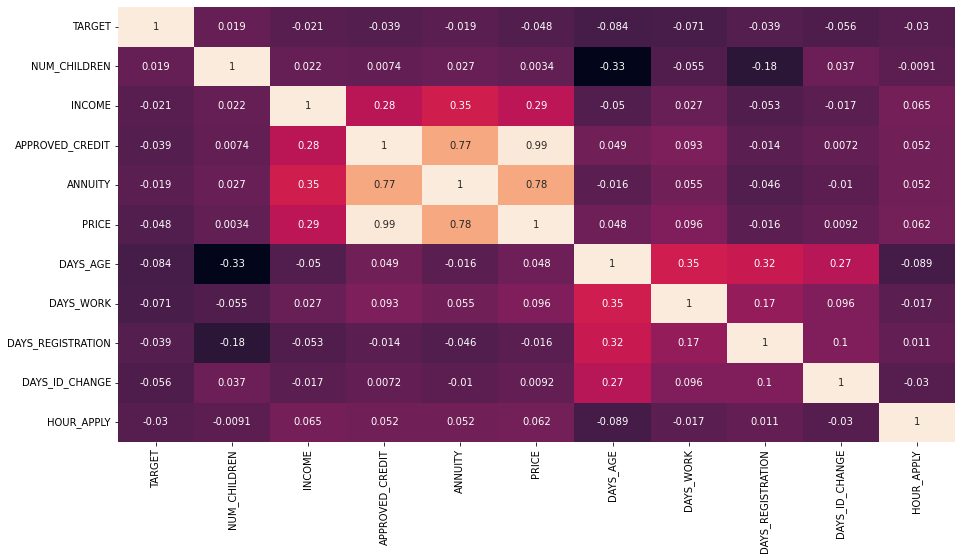

In [7]:
plt.figure(figsize=(15, 8))
sns.heatmap(df.corr(), annot = True, cbar = False)
plt.show()

In [8]:
import dython
from dython.nominal import associations, cramers_v, theils_u, correlation_ratio

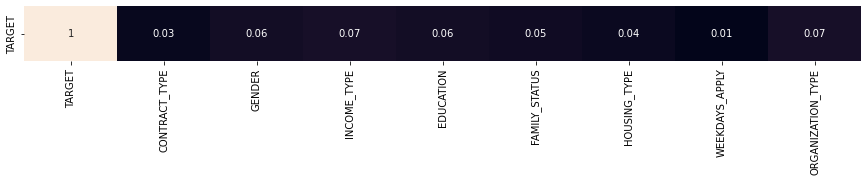

In [55]:
assoc_cr = []
col = ['NUM_CHILDREN', 'INCOME', 'APPROVED_CREDIT', 'ANNUITY', 'PRICE', 'DAYS_AGE', 'DAYS_WORK', 'DAYS_REGISTRATION', 'DAYS_ID_CHANGE', 'HOUR_APPLY']
for i in df.drop(columns = col).columns:
    assoc = round(cramers_v(df['TARGET'], df[i]), 2)
    assoc_cr.append(assoc)

df_cr = pd.DataFrame(data = [assoc_cr], columns = df.drop(columns = col).columns, index = ['TARGET'])

plt.figure(figsize = (15,1))
sns.heatmap(df_cr, annot = True, cbar = False)
plt.show()

In [7]:
pd.crosstab(df['TARGET'],columns='Percentage',normalize=True)*100

col_0,Percentage
TARGET,
0,91.922201
1,8.077799


Sekarang mari kita melakukan fitur encoding untuk fitur2 categorical yang kita miliki.
Yang akan kita lakukan adalah :

1. Merubah fitur/kolom `CONTRACT_TYPE` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
2. Merubah fitur/kolom `GENDER` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
3. Merubah fitur/kolom `INCOME_TYPE` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
4. Merubah fitur/kolom `EDUCATION` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan kita tidak tau berapa besar setiap jarak pastinya, maka akan lebih aman dan akurat bila kita menggunakan One Hot Encoding, selain itu jumlah unique datanya hanya sedikit.
5. Merubah fitur/kolom `FAMILY_STATUS` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
6. Merubah fitur/kolom `WEEKDAYS_APPLY` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
7. Merubah fitur/kolom `ORGANIZATION_TYPE` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
1. Merubah fitur/kolom `HOUSING_TYPE` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.

In [8]:
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), ['CONTRACT_TYPE', 'GENDER', 'INCOME_TYPE', 'EDUCATION', 'FAMILY_STATUS', 'HOUSING_TYPE', 'WEEKDAYS_APPLY', 'ORGANIZATION_TYPE'])
], remainder='passthrough')

In [9]:
X = df.drop(columns=['TARGET'])
y = df['TARGET']

In [10]:
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.2,random_state=42)

In [11]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()

In [12]:
models = [logreg,knn,dt,rf,xgb]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    model_cv=cross_val_score(estimator,X_train,y_train,cv=skfold,scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost'],'mean roc_auc':rata,'sdev':std}).set_index('model').sort_values(by='mean roc_auc',ascending=False)

,mean roc_auc,sdev
model,,
XGBoost,0.637651,0.005979
Random Forest,0.628996,0.008447
Logistic Regression,0.616015,0.002059
KNN,0.544919,0.005620
Decision Tree,0.515551,0.005326


It can be seen that the XGBoost model is the best model for its roc_auc of any model that uses the default hyperparameter

In [13]:
models = [logreg,knn,dt,rf,xgb]
score_roc_auc = []

def y_pred_func(i):
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    X_train,X_test
    
    estimator.fit(X_train,y_train)
    return(estimator,estimator.predict(X_test),X_test)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost']):
    estimator,y_pred,X_test = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(X_test)[:,1]
    score_roc_auc.append(roc_auc_score(y_test,y_predict_proba))
    print(j,'\n', classification_report(y_test,y_pred))
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost'],
             'roc_auc score':score_roc_auc}).set_index('model').sort_values(by='roc_auc score',ascending=False)

Logistic Regression 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     11295
           1       0.00      0.00      0.00       993

    accuracy                           0.92     12288
   macro avg       0.46      0.50      0.48     12288
weighted avg       0.84      0.92      0.88     12288

KNN 
               precision    recall  f1-score   support

           0       0.92      0.99      0.95     11295
           1       0.17      0.02      0.03       993

    accuracy                           0.91     12288
   macro avg       0.55      0.51      0.49     12288
weighted avg       0.86      0.91      0.88     12288

Decision Tree 
               precision    recall  f1-score   support

           0       0.92      0.91      0.92     11295
           1       0.11      0.12      0.12       993

    accuracy                           0.85     12288
   macro avg       0.52      0.52      0.52     12288
weighted avg       0.86      0

,roc_auc score
model,
XGBoost,0.648790
Random Forest,0.635097
Logistic Regression,0.634295
KNN,0.544534
Decision Tree,0.518170


The XGBoost model is still the best performing on the test data.

Now I will try to oversampling our XGBoost model to see if we can get even better results.

### Test Oversampling with K-Fold Cross Validation

In [15]:
def calc_train_error(X_train, y_train, model):
#     '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    predictProba = model.predict_proba(X_train)
    accuracy = accuracy_score(y_train, predictions)
    f1 = f1_score(y_train, predictions, average='macro')
    roc_auc = roc_auc_score(y_train, predictProba[:,1])
    recall = recall_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    report = classification_report(y_train, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_validation_error(X_test, y_test, model):
#     '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    predictProba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    roc_auc = roc_auc_score(y_test, predictProba[:,1])
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
#     '''fits model and returns the in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [16]:
K = 10
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
data = X_train
target = y_train

In [17]:
train_errors_without_oversampling = []
validation_errors_without_oversampling = []

train_errors_with_oversampling = []
validation_errors_with_oversampling = []

for train_index, val_index in kf.split(data, target):
    
    # split data
    X_train_1, X_val = data.iloc[train_index], data.iloc[val_index]
    y_train_1, y_val = target.iloc[train_index], target.iloc[val_index]
    
#     print(len(X_val), (len(X_train) + len(X_val)))
    ros = RandomOverSampler()

    X_ros, y_ros = ros.fit_resample(X_train_1, y_train_1)

    # instantiate model
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',xgb)
    ])

    #calculate errors
    train_error_without_oversampling, val_error_without_oversampling = calc_metrics(X_train_1, y_train_1, X_val, y_val, estimator)
    train_error_with_oversampling, val_error_with_oversampling = calc_metrics(X_ros, y_ros, X_val, y_val, estimator)
    
    # append to appropriate list
    train_errors_without_oversampling.append(train_error_without_oversampling)
    validation_errors_without_oversampling.append(val_error_without_oversampling)
    
    train_errors_with_oversampling.append(train_error_with_oversampling)
    validation_errors_with_oversampling.append(val_error_with_oversampling)

#### Evaluation Metrics Without Oversampling

In [18]:
listItem = []

for tr,val in zip(train_errors_without_oversampling,validation_errors_without_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.925151,0.918836,0.917459,0.651857,0.548983,0.483805,0.073608,0.005038,0.996212,0.333333
1,0.925717,0.918023,0.914207,0.651965,0.554934,0.488344,0.080325,0.010076,1.000000,0.285714
2,0.925040,0.918210,0.912882,0.617430,0.548190,0.483598,0.072768,0.005038,0.988593,0.222222
3,0.925379,0.919023,0.916907,0.639442,0.551906,0.486314,0.076966,0.007557,0.989209,0.428571
4,0.926419,0.919227,0.917297,0.660155,0.562914,0.486388,0.089561,0.007557,0.993789,0.500000
5,0.924724,0.918820,0.916652,0.672307,0.544012,0.481336,0.068010,0.002519,1.000000,0.250000
6,0.926238,0.917396,0.920349,0.656941,0.561625,0.478459,0.088161,0.000000,0.984375,0.000000
7,0.925673,0.918210,0.918724,0.638506,0.555323,0.483598,0.080884,0.005038,0.986348,0.222222
8,0.926193,0.917803,0.922666,0.631191,0.560711,0.483463,0.087042,0.005038,0.990446,0.181818
9,0.926216,0.918820,0.922189,0.643068,0.560522,0.488656,0.086762,0.010076,0.996785,0.400000


#### Evaluation Metrics With Oversampling

In [19]:
listItem = []

for tr,val in zip(train_errors_with_oversampling,validation_errors_with_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.866722,0.755696,0.937341,0.641433,0.866433,0.535432,0.913164,0.415617,0.835554,0.145503
1,0.870374,0.756916,0.939049,0.642281,0.870078,0.534774,0.918058,0.408060,0.838127,0.144385
2,0.865495,0.749746,0.937834,0.609111,0.865158,0.524955,0.915478,0.382872,0.832279,0.133685
3,0.860700,0.750356,0.935348,0.634168,0.860448,0.526868,0.903207,0.390428,0.832438,0.135965
4,0.861819,0.757681,0.933875,0.648771,0.861559,0.541720,0.905150,0.440806,0.832964,0.152972
5,0.854220,0.757884,0.929793,0.667480,0.853949,0.546643,0.897305,0.465995,0.826118,0.159071
6,0.863491,0.745473,0.936986,0.629824,0.863224,0.526598,0.907658,0.405542,0.833989,0.136905
7,0.863331,0.751780,0.936772,0.629045,0.863010,0.525788,0.911789,0.380353,0.831230,0.134222
8,0.856421,0.742625,0.931146,0.635569,0.856157,0.515800,0.899247,0.360202,0.828301,0.123917
9,0.863885,0.758901,0.937805,0.633658,0.863622,0.537654,0.907756,0.415617,0.834532,0.147585


Dari hasil evaluation metrics, hasil recall(+) setelah dilakukan oversampling akan akan lebih baik daripada sebelum dilakukan oversampling, namun hasil precision(+) lebih rendah daripada sebelum dilakukan oversampling. Hal ini dikarenakan adanya tradeoff dalam kenaikan recall dan penurunan precision dikarenakan, jumlah data dari kelas minoritas sama dengan kelas mayoritasnya. 

In [20]:
for rep in validation_errors_without_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4519
           1       0.33      0.01      0.01       397

    accuracy                           0.92      4916
   macro avg       0.63      0.50      0.48      4916
weighted avg       0.87      0.92      0.88      4916

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4519
           1       0.29      0.01      0.02       397

    accuracy                           0.92      4916
   macro avg       0.60      0.50      0.49      4916
weighted avg       0.87      0.92      0.88      4916

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4518
           1       0.22      0.01      0.01       397

    accuracy                           0.92      4915
   macro avg       0.57      0.50      0.48      4915
weighted avg       0.86      0.92      0.88      4915

              preci

In [26]:
for rep in validation_errors_with_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      4519
           1       0.11      0.13      0.12       397

    accuracy                           0.85      4916
   macro avg       0.52      0.52      0.52      4916
weighted avg       0.86      0.85      0.85      4916

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      4519
           1       0.12      0.13      0.12       397

    accuracy                           0.85      4916
   macro avg       0.52      0.52      0.52      4916
weighted avg       0.86      0.85      0.86      4916

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      4518
           1       0.11      0.12      0.11       397

    accuracy                           0.85      4915
   macro avg       0.51      0.52      0.52      4915
weighted avg       0.86      0.85      0.85      4915

              preci

### Hyperparameter Tuning

In [21]:
pipe_XGB = Pipeline([
    ('prep', transformer),
    ('algo', XGBClassifier())
])

param_XGB = {
    "algo__n_estimators" : np.arange(50, 601, 50),
    "algo__max_depth" : np.arange(1, 10),
    "algo__learning_rate" : np.logspace(-3, 0, 4),
    "algo__gamma" : np.logspace(-3, 0, 6),
    "algo__colsample_bytree" : [0.3, 0.5, 0.7, 0.8],
    "algo__subsample" : [0.3, 0.5, 0.7, 0.8],
    "algo__reg_alpha" : np.logspace(-3, 3, 7),
    "algo__reg_lambda" : np.logspace(-3, 3, 7)
}

skf = StratifiedKFold(n_splits=10)

In [37]:
GS_XGB = GridSearchCV(pipe_XGB, param_XGB, cv = skf, scoring='roc_auc', verbose = 3, n_jobs=-1)

In [38]:
RS_XGB = RandomizedSearchCV(pipe_XGB, param_XGB,cv = skf, scoring='roc_auc', verbose = 3, n_jobs=-1 )

In [39]:
RS_XGB.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehot',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['CONTRACT_TYPE',
                                                                                'GENDER',
                                                                                'INCOME_TYPE',
                                                                                'EDUCATION',
                                                                                'FAMILY_STATUS',
                                                                                'HOUSING_TYPE',
                                                                                'WEEKDAYS_APPLY',
                                                                                'ORGANIZATION_T...
                                        'algo__learning_rate': array([0.001, 0.01 , 0.1  , 1.   ]),
                                        'algo__max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'algo__n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]),
                                        'algo__reg_alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'algo__reg_lambda': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'algo__subsample': [0.3, 0.5, 0.7,
                                                            0.8]},
                   scoring='roc_auc', verbose=3)

In [40]:
RS_XGB.best_params_

{'algo__subsample': 0.7,
 'algo__reg_lambda': 0.1,
 'algo__reg_alpha': 100.0,
 'algo__n_estimators': 600,
 'algo__max_depth': 2,
 'algo__learning_rate': 1.0,
 'algo__gamma': 0.25118864315095796,
 'algo__colsample_bytree': 0.8}

In [41]:
XGB_Tuned = RS_XGB.best_estimator_

In [42]:
print(classification_report(y_test, XGB_Tuned.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     11295
           1       0.00      0.00      0.00       993

    accuracy                           0.92     12288
   macro avg       0.46      0.50      0.48     12288
weighted avg       0.84      0.92      0.88     12288



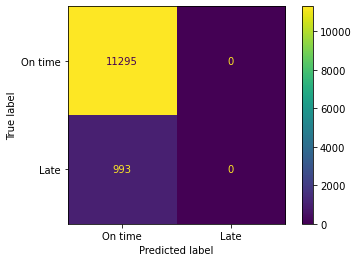

In [46]:
plot_confusion_matrix(XGB_Tuned, X_test, y_test, display_labels=['On time', 'Late'])

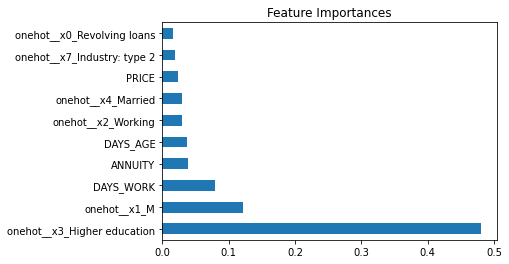

In [43]:
coef1 = pd.Series(XGB_Tuned['algo'].feature_importances_, transformer.get_feature_names()).sort_values(ascending = False).head(10)
coef1.plot(kind='barh', title='Feature Importances')
plt.show()

Terlihat bahwa ternyata untuk model XGB ini, fitur `higher education` adalah yang paling penting, kemudian diikuti dengan gender `M`, `days work`, `Annuity`, dan seterusnya. 

Selain itu feature importance juga bisa ditinjau lebih lanjut dengan melakukan EDA.